In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import time

N_Z_PARAMS = 8

In [2]:
!nvidia-smi

Thu Mar 11 15:01:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8    18W / 250W |      1MiB / 11175MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
class DiscriminativeNet(torch.nn.Module):
    """
    A two hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        n_features = 2
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 8),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(8, 4),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(4, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

class GenerativeNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """

    def __init__(self):
        super(GenerativeNet, self).__init__()
        n_features = N_Z_PARAMS
        n_out = 2

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 4),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(4, 8),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(8, n_out)
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

def noise(size):
    n = torch.randn(size, N_Z_PARAMS)
    n = n.to(device) 
    return n

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    data = data.to(device)
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    data = data.to(device)
    return data

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def plt_output(fake_data):
    plt.figure(figsize=(8,8))
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    plt.scatter(fake_data[:,0],fake_data[:,1])
    plt.show()

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

In [5]:
def pdata_sample(size):
    mean = np.array([2, 3])
    cov = np.array([[4, -3], [-3, 9]])
    return np.random.multivariate_normal(mean, cov, size)

def plot_data(fig, ax, X1, X2, labels):
    plt.title('Sample')
    ax.plot(X1[:,0], X1[:,1], 'ro', label=labels[0])
    ax.plot(X2[:,0], X2[:,1], 'bo', label=labels[1])
    ax.axis('equal')
    ax.legend()

In [6]:
#train
X = pdata_sample(1000)
samples = torch.Tensor(X)
dataset = torch.utils.data.TensorDataset(samples)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
num_batches = len(data_loader)

In [7]:
#Test
num_test_samples = 100
test_data_real = pdata_sample(num_test_samples)
test_noise = noise(num_test_samples)

In [8]:
# Create generator and discriminator

discriminator = DiscriminativeNet()
generator = GenerativeNet()

if torch.cuda.is_available():
    generator.to(device)
    discriminator.to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

Epoch 0 generator loss 0.078755 discriminator loss 0.131992
Epoch 1 generator loss 0.078520 discriminator loss 0.130703
Epoch 2 generator loss 0.078578 discriminator loss 0.131251
Epoch 3 generator loss 0.078391 discriminator loss 0.130548
Epoch 4 generator loss 0.078428 discriminator loss 0.129913
Epoch 5 generator loss 0.078343 discriminator loss 0.129024
Epoch 6 generator loss 0.078352 discriminator loss 0.128897
Epoch 7 generator loss 0.078162 discriminator loss 0.126838
Epoch 8 generator loss 0.078084 discriminator loss 0.127179
Epoch 9 generator loss 0.078149 discriminator loss 0.126878


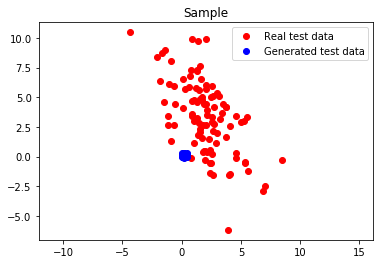

In [12]:
#Training process
num_epochs = 10
d_error_arr = []
g_error_arr = []
fig,ax = plt.subplots(1,1)
for epoch in range(num_epochs):
    n_batches = 0
    g_err = 0
    d_err = 0
    for n_batch, [real_data] in enumerate(data_loader):

        # Train Discriminator
        real_data = Variable(real_data)   
        real_data = real_data.to(device)
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                    real_data, fake_data)
        d_err += d_error.cpu().detach().numpy()

        # Train Generator
            
        fake_data = generator(noise(real_data.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        g_err += g_error.cpu().detach().numpy()
        n_batches = n_batches + 1
    g_error_arr.append(g_error/n_batches)
    d_error_arr.append(d_error/n_batches)  
    print('Epoch %d generator loss %f discriminator loss %f' %
                (epoch, g_error_arr[epoch], d_error_arr[epoch]))
    test_data_fake = generator(test_noise).cpu().detach()
plot_data(fig, ax, test_data_real, test_data_fake, ['Real test data', 'Generated test data'])